In [121]:
# Data manipulation libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.stats import chi2_contingency

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling and Metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")

# calculating the geographical distance
from geopy.distance import geodesic



The objective of this project is to develop a highly effective machine learning model for detecting credit card fraud. The project focuses on the following key aspects:

Fraud Detection: Building a model capable of accurately classifying transactions as either legitimate or fraudulent.

Model Comparison: Evaluating and comparing the performance of various machine learning models, including Logistic Regression, Decision Tree, Random Forest, and XGBoost.

Evaluation Metrics: Emphasizing the use of meaningful metrics such as precision, recall, F1-score, and ROC-AUC to account for class imbalance, rather than relying solely on accuracy.

In [ ]:
base_path = os.path.expanduser('~/Desktop/Project 737')  
file_name = 'credit_card_transactions.csv'
file_path = os.path.join(base_path, file_name)

# Read the CSV file
credit_df = pd.read_csv(file_path)
credit_df.head(2)

#credit_df = pd.read_csv('/Users/anushkachougule/Desktop/Project 737/credit_card_transactions.csv')
#credit_df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN


In [61]:
print(f"Number of rows: {credit_df.shape[0]}")
print(f"Number of columns: {credit_df.shape[1]}")

Number of rows: 1296675
Number of columns: 24


In [62]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

The dataset contains 1,296,675 rows and 24 columns, with various data types including integers, floats, and objects; most columns have complete data, except for merch_zipcode which has missing values.

In [63]:
credit_df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.100702e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,4.682575e+04
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,2.583400e+04
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,1.001000e+03
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,2.511400e+04
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,4.586000e+04
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,6.831900e+04
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.940300e+04


The dataset's numerical summary reveals key statistics such as means, standard deviations, and range (min to max) for 12 columns, with notable features like amt (transaction amount) ranging from $1 to $28,948.90, and is_fraud indicating a maximum of 1, signifying binary fraud classification.

In [64]:
#Examining if there is any missing data.
missing_counts = credit_df.isnull().sum()
missing_counts_df = pd.DataFrame(missing_counts).reset_index()
missing_counts_df.columns = ['Feature', 'Missing Value Count']
missing_counts_df

,Feature,Missing Value Count
0,Unnamed: 0,0
1,trans_date_trans_time,0
2,cc_num,0
3,merchant,0
4,category,0
5,amt,0
6,first,0
7,last,0
8,gender,0
9,street,0


In [65]:
#Checking the number of unique values in each column.
unique_counts = credit_df.nunique()
unique_counts_df = pd.DataFrame(unique_counts).reset_index()
unique_counts_df.columns = ['Feature', 'Number of Unique Values'] 
unique_counts_df

,Feature,Number of Unique Values
0,Unnamed: 0,1296675
1,trans_date_trans_time,1274791
2,cc_num,983
3,merchant,693
4,category,14
5,amt,52928
6,first,352
7,last,481
8,gender,2
9,street,983


In [66]:
# Check if there is any duplications.
print(f'Number of duplicated rows: {credit_df.duplicated().sum()}')

Number of duplicated rows: 0


Exploratory Data Analysis

In [67]:
fraud_df = credit_df.copy()

In [68]:
#Check for percent of fraud and non-frauds in the data
print('No Frauds', round(fraud_df['is_fraud'].value_counts()[0]/len(fraud_df) * 100,2), '% of the dataset')
print('Frauds', round(fraud_df['is_fraud'].value_counts()[1]/len(fraud_df) * 100,2), '% of the dataset')

No Frauds 99.42 % of the dataset
Frauds 0.58 % of the dataset


The results indicate a severe class imbalance in the dataset, with 99.42% of transactions being non-fraudulent and only 0.58% being fraudulent. This is a common scenario in fraud detection datasets, and the imbalance reflects real-world conditions where fraudulent transactions are rare events compared to legitimate ones

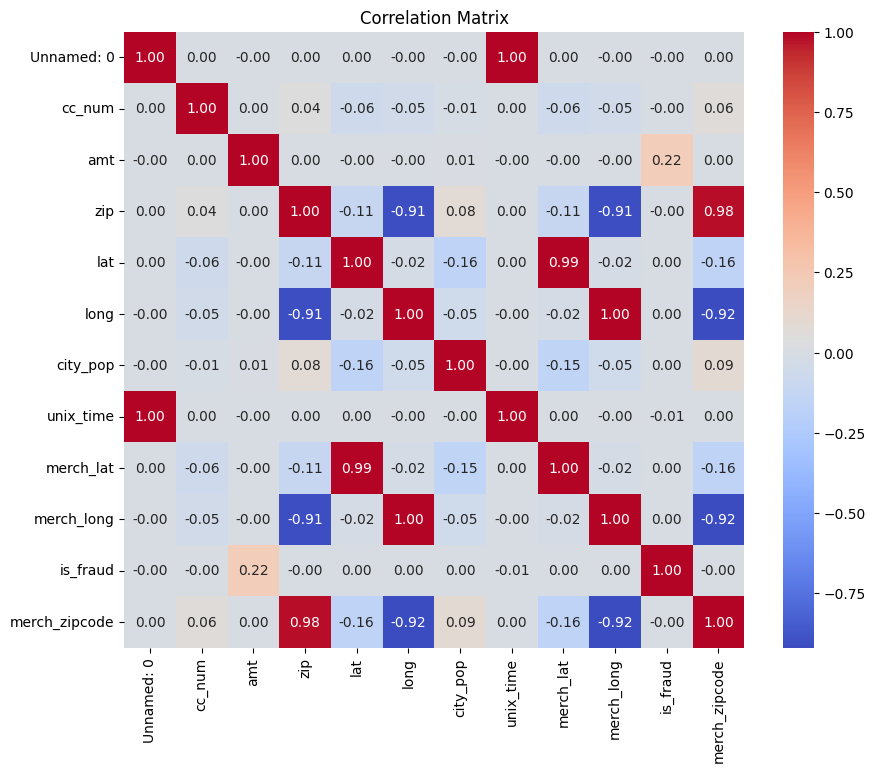

In [69]:
fraud_df['trans_date_trans_time'] = pd.to_datetime(fraud_df['trans_date_trans_time'])
numerical_df = fraud_df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

The correlation matrix heatmap reveals strong positive correlations between geographic variables (e.g., lat and merch_lat: 0.99, long and merch_long: 0.91) and high redundancy between zip and merch_zipcode (0.98). A moderate correlation between amt and is_fraud (0.22) suggests transaction amount influences fraud detection. These insights inform feature selection and highlight key variables for modeling.

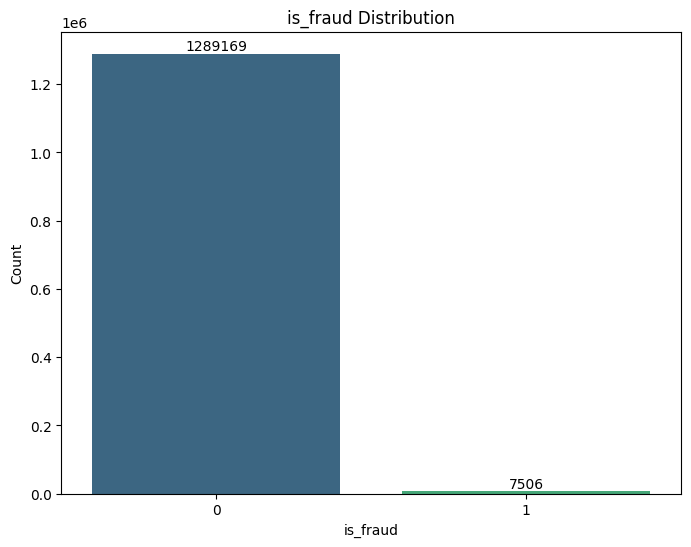

In [70]:
# visualize the is_fraud column which indicates fraud.
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_fraud', data=fraud_df, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black')
plt.title('is_fraud Distribution')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.show()

As observed, our dataset exhibits a highly imbalanced distribution, with only 7,506 transactions (0.58%) classified as fraudulent.

In [ ]:
contingency_table = pd.crosstab(credit_df['category'], credit_df['is_fraud'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p}")

# Interpretation
if p < 0.05:
    print("There is a significant association between transaction category and fraud occurrence.")
else:
    print("No significant association between transaction category and fraud occurrence.")


Chi-Square Statistic: 6486.003269983207
Degrees of Freedom: 13
P-Value: 0.0
There is a significant association between transaction category and fraud occurrence.


The chi-square test results reveal a p-value of 0.0, significantly below the threshold of 0.05, leading to the rejection of the null hypothesis. This indicates a strong association between transaction category and fraud occurrence, suggesting that the likelihood of fraud varies significantly across different categories. Notably, certain categories, such as "misc_net" and "grocery_pos," emerge as high-risk for fraudulent activity. These findings underscore the importance of targeted fraud prevention measures, enabling businesses to focus their resources on monitoring and safeguarding these vulnerable categories.

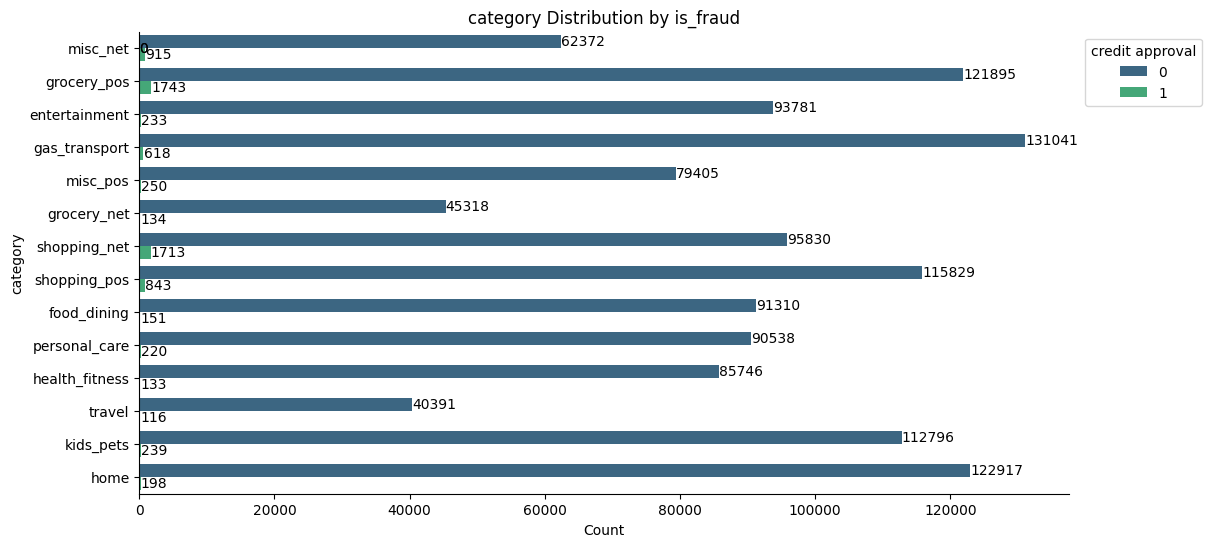

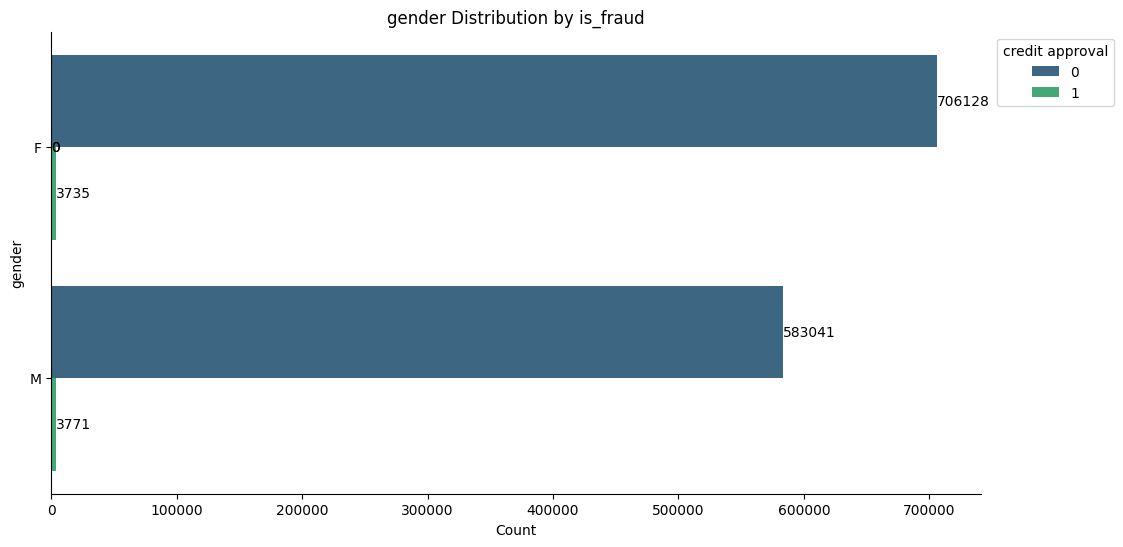

In [71]:
# Visualization of the is_fraud distribution based on some categorical variables using a bar chart.
categorical_columns = ['category', 'gender']

for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(y=column, hue='is_fraud', data=fraud_df, palette='viridis')
    plt.title(f'{column} Distribution by is_fraud')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.legend(title='credit approval', loc='upper right', bbox_to_anchor=(1.15, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 10, p.get_y() + p.get_height() / 2, 
                f'{int(width)}', 
                ha='left', va='center')

    plt.show()

The first plot illustrates the distribution of fraudulent (is_fraud = 1) and legitimate (is_fraud = 0) transactions across different categories. 
Certain categories, such as Category 4 and Category 11, have a relatively higher number of fraudulent transactions compared to others.
Most categories are dominated by legitimate transactions due to the imbalanced nature of the dataset.

The second plot highlights the distribution of fraudulent and legitimate transactions across gender:
Both genders show a similar pattern, with fraudulent transactions being extremely rare compared to legitimate ones.
The number of fraudulent transactions is slightly higher for gender = 1, but the difference is minimal, indicating that fraud is not strongly influenced by gender.

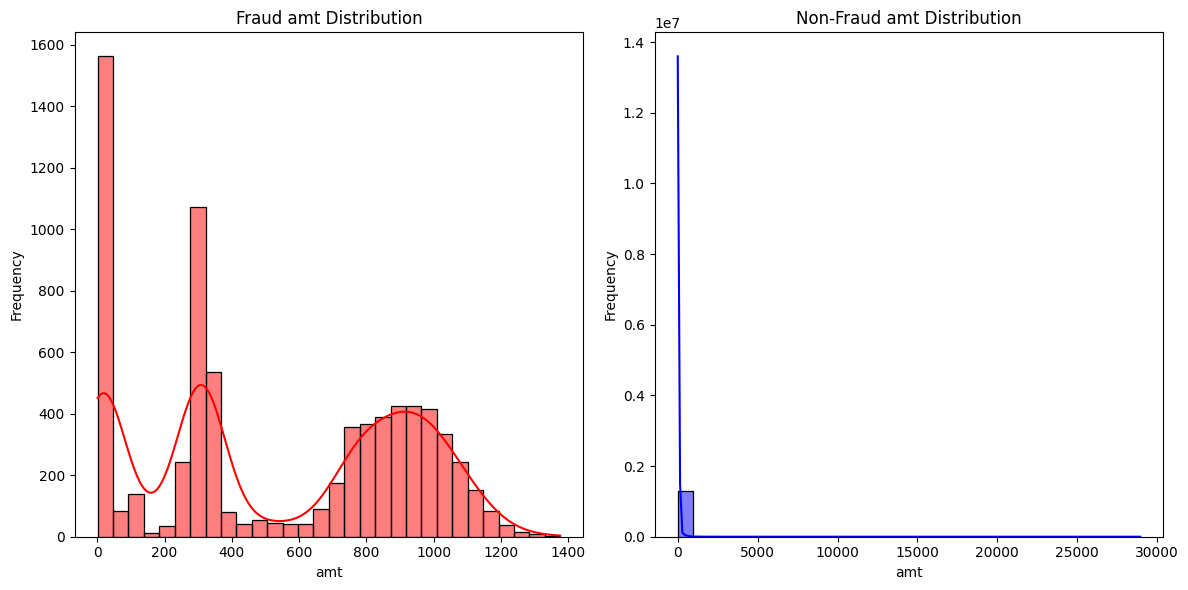

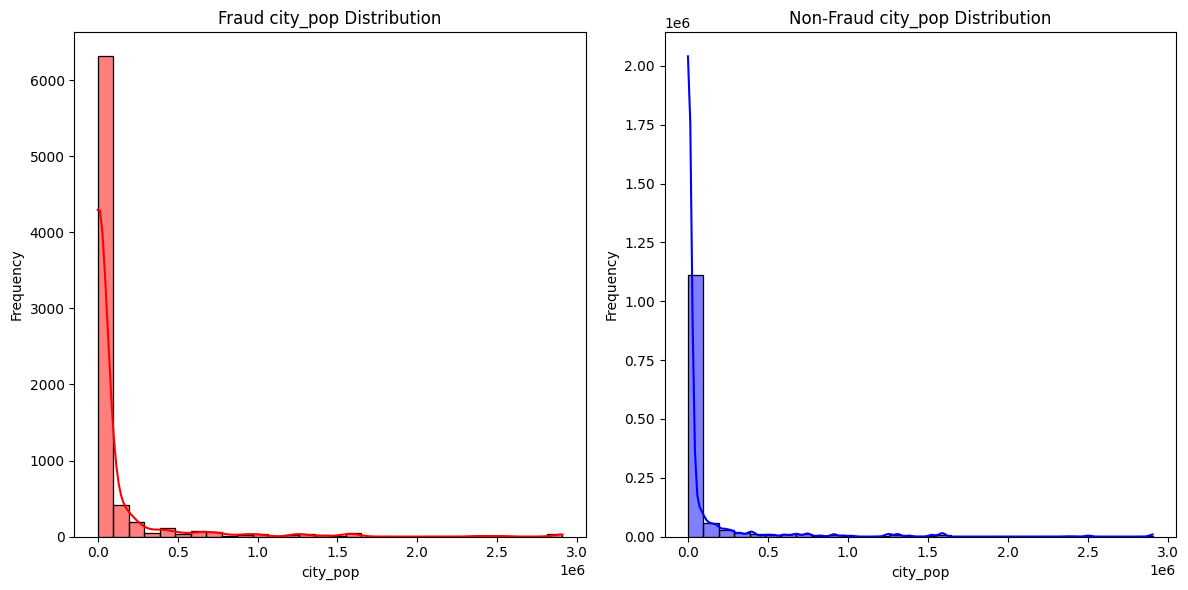

In [72]:
#Let's plot the histograms for some of the numerical features.
numeric_columns = ['amt', 'city_pop']

for column in numeric_columns:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(fraud_df[fraud_df['is_fraud'] == 1][column], bins=30, kde=True, color='red')
    plt.title(f'Fraud {column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(fraud_df[fraud_df['is_fraud'] == 0][column], bins=30, kde=True, color='blue')
    plt.title(f'Non-Fraud {column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Both features (amt and city_pop) exhibit highly skewed distributions, which may require preprocessing steps like scaling or transformations to improve model performance.
Transaction amount (amt) appears to be a stronger distinguishing feature for fraud detection compared to city population (city_pop).
Fraudulent transactions are typically associated with moderate amounts and occur more frequently in less populated areas, suggesting potential targeting or specific vulnerabilities in these regions.


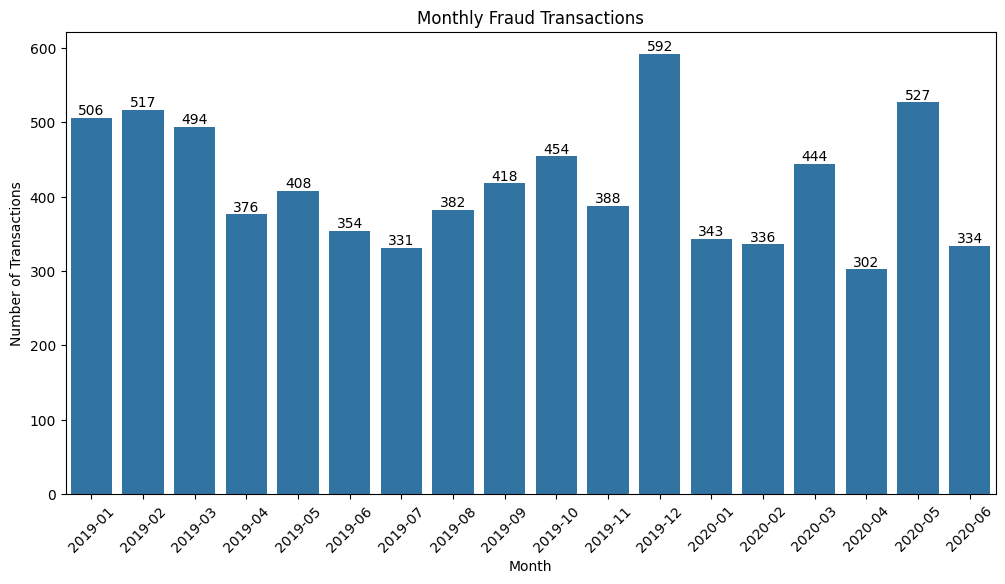

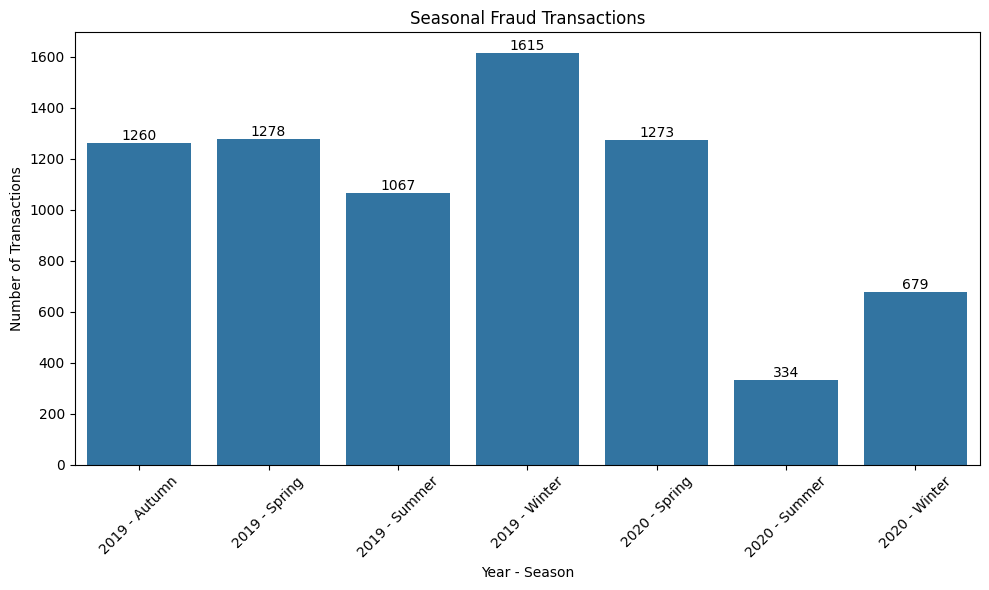

In [73]:
#Visualizing monthly and yearly fraud transactions.
df_copy = fraud_df.copy()
fraud_transactions = df_copy[df_copy['is_fraud'] == 1]
non_fraud_transactions = df_copy[df_copy['is_fraud'] == 0]

fraud_transactions['trans_date_trans_time'] = pd.to_datetime(fraud_transactions['trans_date_trans_time'])
monthly_counts = fraud_transactions['trans_date_trans_time'].dt.to_period('M').value_counts().sort_index()
fraud_transactions['season'] = fraud_transactions['trans_date_trans_time'].dt.month % 12 // 3 + 1
fraud_transactions['year'] = fraud_transactions['trans_date_trans_time'].dt.year
fraud_transactions['year_season'] = fraud_transactions['year'].astype(str) + ' - ' + fraud_transactions['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})
seasonal_counts = fraud_transactions['year_season'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values)
plt.title('Monthly Fraud Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

for i, count in enumerate(monthly_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=seasonal_counts.index, y=seasonal_counts.values)
plt.title('Seasonal Fraud Transactions')
plt.xlabel('Year - Season')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

for i, count in enumerate(seasonal_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Fraudulent transactions vary across months, with noticeable peaks in December 2019 (592) and May 2020 (527).
The lowest number of fraudulent transactions is observed in March 2020 (302).
There is no clear upward or downward trend over time, suggesting fluctuations in fraud activity across months.
December and May appear to have higher fraudulent activity, which could be related to holiday seasons, increased spending, or specific patterns of fraudulent behavior during these months.

Winter 2019 exhibits the highest number of fraudulent transactions (1615), followed by Spring 2019 (1278) and Spring 2020 (1273).
Summer 2020 has the lowest number of fraudulent transactions (334), indicating significantly reduced fraud activity during this period.
Winter consistently shows higher fraudulent activity, which might correlate with increased financial transactions during the holiday season. Summer shows lower activity, possibly due to reduced consumer spending or other seasonal factors.


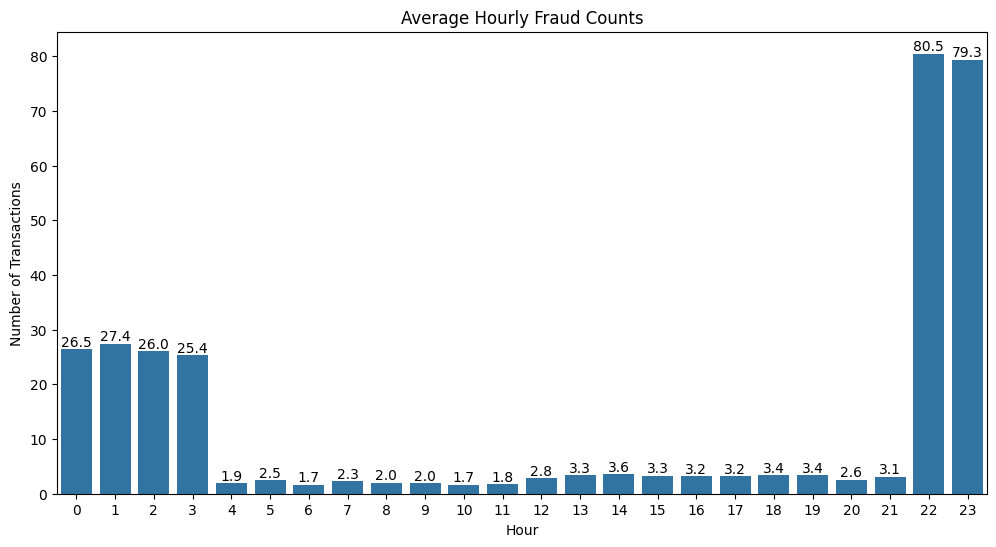

In [74]:
#which hours have a higher occurrence of fraudulent transactions.
fraud_transactions['hour'] = fraud_transactions['trans_date_trans_time'].dt.hour
hourly_fraud_counts = fraud_transactions['hour'].value_counts().sort_index()
average_hourly_fraud_counts = hourly_fraud_counts / fraud_transactions['hour'].value_counts().count()

plt.figure(figsize=(12, 6))
sns.barplot(x=average_hourly_fraud_counts.index, y=average_hourly_fraud_counts.values)
plt.title('Average Hourly Fraud Counts')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)

for i, count in enumerate(average_hourly_fraud_counts.values):
    plt.text(i, count, f"{count:.1f}", ha='center', va='bottom')

plt.show()

Fraudulent transactions are significantly higher during the late evening hours (10 PM to midnight), with an average of 80.5 and 79.3 transactions at 10 PM (22) and 11 PM (23), respectively.
The number of fraudulent transactions is consistently low during the daytime and early morning hours, particularly between 4 AM and 8 AM, where the average count is less than 3 transactions per hour.

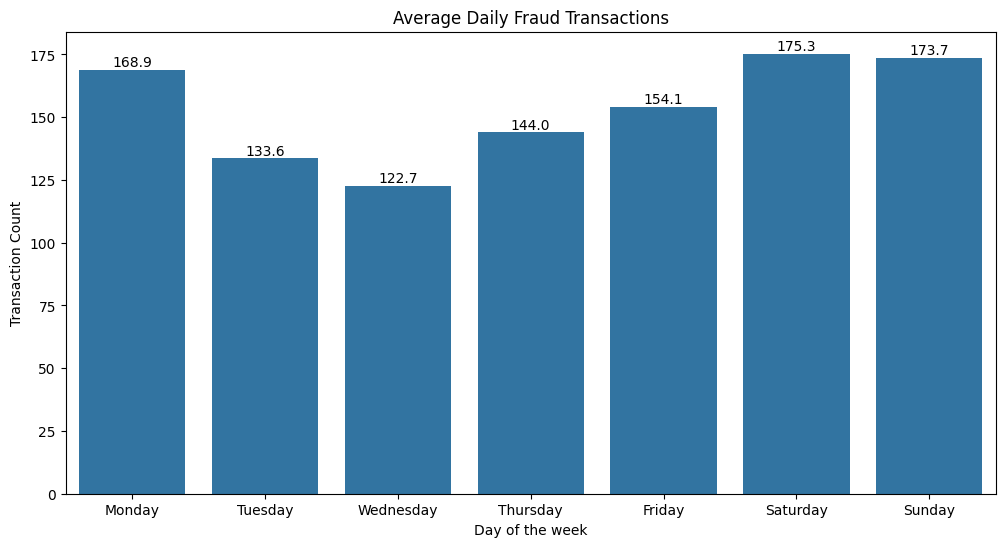

In [75]:
#Calculating and visualising the average number of fraud transactions for each day of the week.
fraud_transactions['weekday'] = fraud_transactions['trans_date_trans_time'].dt.weekday
weekday_fraud_counts = fraud_transactions['weekday'].value_counts().sort_index()
average_weekday_fraud_counts = weekday_fraud_counts / fraud_transactions['weekday'].value_counts().count()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.barplot(x=average_weekday_fraud_counts.index, y=average_weekday_fraud_counts.values)
plt.title('Average Daily Fraud Transactions')
plt.xlabel('Day of the week')
plt.ylabel('Transaction Count')
plt.xticks(ticks=average_weekday_fraud_counts.index, labels=days_of_week, rotation=0)

for i, count in enumerate(average_weekday_fraud_counts.values):
    plt.text(i, count, f"{count:.1f}", ha='center', va='bottom')

plt.show()

Saturday has the highest average fraud count (175.3 transactions), closely followed by Sunday (173.7 transactions).
Fraudulent activity is lower on weekdays, with Wednesday having the lowest average fraud count (122.7 transactions).
There is a noticeable rise in fraudulent transactions on Friday (154.1 transactions), leading into the weekend.

Data Manipulation

The only numerical variable suitable for outlier detection in this dataset is the transaction amount (amt). Other numerical features, such as population, latitude, and longitude, do not have meaningful statistical significance or relevant distributions in this context.

To identify and remove outliers, we will consider data points above a certain threshold in the amt column. To determine an appropriate threshold, I will first analyze the structure of the amt variable by plotting a scatterplot.

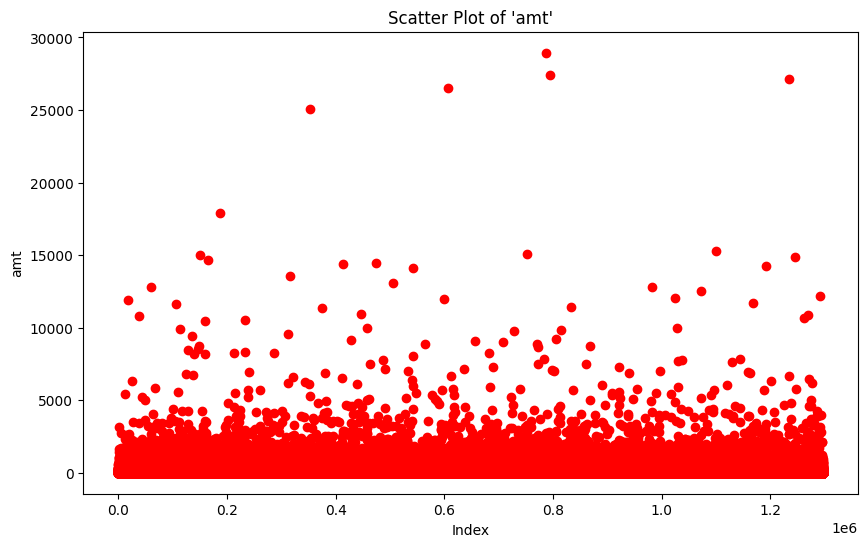

In [76]:
plt.figure(figsize=(10, 6))  
plt.scatter(fraud_df.index, fraud_df['amt'], color='red') 
plt.title("Scatter Plot of 'amt'")  
plt.xlabel('Index')  
plt.ylabel('amt')  
plt.show()  

Based on the scatterplot, it is evident that the data points begin to disperse significantly for transaction amounts (amt) beyond the range of 2500 to 3000. To address this, I will set the outlier threshold at 2700 and visualize the results to confirm its effectiveness.

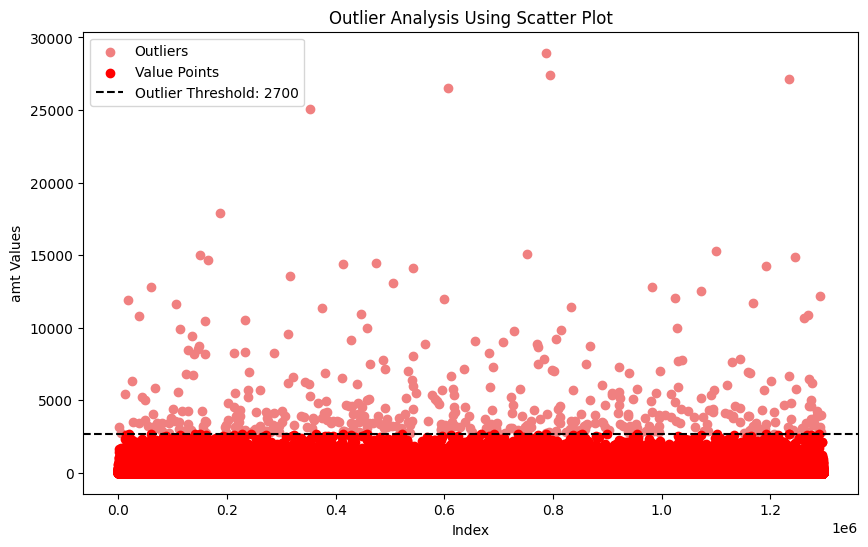

Number of outliers: 430
Outlier percentage: % 0.033161740605780164


In [77]:
outlier_threshold = 2700
outliers = fraud_df['amt'] > outlier_threshold
outlier_count = np.count_nonzero(outliers)
total_count = len(fraud_df)
outlier_percentage = (outlier_count / total_count) * 100

plt.figure(figsize=(10, 6))
plt.scatter(fraud_df.index[outliers], fraud_df['amt'][outliers], color='lightcoral', label='Outliers')
plt.scatter(fraud_df.index[~outliers], fraud_df['amt'][~outliers], color='red', label='Value Points')
plt.axhline(y=outlier_threshold, color='black', linestyle='--', label=f'Outlier Threshold: {outlier_threshold}')
plt.title('Outlier Analysis Using Scatter Plot')
plt.xlabel('Index')
plt.ylabel('amt Values')
plt.legend()
plt.show()


print(f'Number of outliers: {outlier_count}')
print(f'Outlier percentage: % {outlier_percentage}')


I will remove all records where the transaction amount (amt) exceeds the threshold of 2700. Based on the analysis, only 430 records qualify as outliers, accounting for 0.03% of the total dataset. Given the minimal percentage of data loss, this removal is not considered significant and will not impact the overall analysis.

In [78]:
fraud_df= fraud_df[~outliers]

Dropping unnecessary features.
Removing the following columns, as they are not necessary for training our model.

Unnamed: 0 - It's a unique number similar to an index, which is meaningless for training purposes.

first - The cardholder's first and last names are irrelevant for training purposes.

last - The cardholder's first and last names are irrelevant for training purposes.

street - Since we already have lat and lon information, we don't need the data in these columns.

city - Since we already have lat and lon information, we don't need the data in these columns.

state - Since we already have lat and lon information, we don't need the data in these columns.

zip - Since we already have lat and lon information, we don't need the data in these columns.

trans_num - It's a unique number for each transaction, which is meaningless for training purposes.

unix_time - We can get the same information from 'trans_date_trans_time' column.

merch_zipcode - Since we already have lat and lon information, we don't need the data in these columns.

In [79]:
to_drop = ['Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip', 'trans_num','unix_time','merch_zipcode']
fraud_df = fraud_df.drop(columns=to_drop)

In [80]:
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0


Feature Engineering

We need to extract the trans_year, trans_month, trans_day, trans_season, trans_weekday, trans_hour, trans_minute, and trans_second columns from the trans_date_trans_time column. Once these new columns are created, the trans_date_trans_time column can be removed.

In [81]:
fraud_df['trans_date_trans_time'] = pd.to_datetime(fraud_df['trans_date_trans_time'])
fraud_df['trans_year'] = fraud_df['trans_date_trans_time'].dt.year
fraud_df['trans_month'] = fraud_df['trans_date_trans_time'].dt.month
fraud_df['trans_day'] = fraud_df['trans_date_trans_time'].dt.day
fraud_df['trans_season'] = fraud_df['trans_date_trans_time'].dt.month % 12 // 3 + 1  #1 = Winter, 2 = Spring, 3 = Summer, 4 = Autumn
fraud_df['trans_weekday'] = fraud_df['trans_date_trans_time'].dt.weekday 
fraud_df['trans_hour'] = fraud_df['trans_date_trans_time'].dt.hour
fraud_df['trans_minute'] = fraud_df['trans_date_trans_time'].dt.minute
fraud_df['trans_second'] = fraud_df['trans_date_trans_time'].dt.second

fraud_df = fraud_df.drop(columns=['trans_date_trans_time'])

Calculate the cardholder's age at the time of the transaction 

In [82]:
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'])
fraud_df['birth_year'] = fraud_df['dob'].dt.year
fraud_df['card_holder_age'] = fraud_df['trans_year'] - fraud_df['birth_year']
data = fraud_df.drop(columns=['dob', 'birth_year'])

We will use the Geopy library to calculate the geographical distance between two points based on their latitude and longitude coordinates. Geopy simplifies this process by providing precise methods to compute distances while accounting for the Earth's curvature.

In [83]:
def calculate_distance(row):
    point_a = (row['lat'], row['long'])
    point_b = (row['merch_lat'], row['merch_long'])
    return geodesic(point_a, point_b).kilometers 

data['distance'] = data.apply(calculate_distance, axis=1)

Encoding

Using LabelEncoder to convert categorical features into numerical values for model training.

In [84]:
def encode_categorical_columns(data, columns):
    le = LabelEncoder()
    for col in columns:
        data[col] = le.fit_transform(data[col])
    return data

cat_features = ['cc_num', 'merchant', 'category', 'gender', 'job']
fraud_df = encode_categorical_columns(fraud_df, cat_features)
fraud_df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,...,trans_year,trans_month,trans_day,trans_season,trans_weekday,trans_hour,trans_minute,trans_second,birth_year,card_holder_age
0,444,514,8,4.97,0,36.0788,-81.1781,3495,370,1988-03-09,...,2019,1,1,1,1,0,0,18,1988,31
1,42,241,4,107.23,0,48.8878,-118.2105,149,428,1978-06-21,...,2019,1,1,1,1,0,0,44,1978,41
2,237,390,0,220.11,1,42.1808,-112.2620,4154,307,1962-01-19,...,2019,1,1,1,1,0,0,51,1962,57
3,509,360,2,45.00,1,46.2306,-112.1138,1939,328,1967-01-12,...,2019,1,1,1,1,0,1,16,1967,52
4,368,297,9,41.96,1,38.4207,-79.4629,99,116,1986-03-28,...,2019,1,1,1,1,0,3,6,1986,33


Scaling and Distribution

In [85]:
# Selecting numerical columns for scaling
numerical_columns = ['amt', 'lat', 'long', 'city_pop', 'card_holder_age']  
scaler = StandardScaler()
robust = RobustScaler()
# Scale the numerical columns
scaled_features = robust.fit_transform(fraud_df[numerical_columns])

# Replace original numerical columns with scaled values
fraud_df[numerical_columns] = scaled_features

In [86]:
fraud_df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,dob,...,trans_year,trans_month,trans_day,trans_season,trans_weekday,trans_hour,trans_minute,trans_second,birth_year,card_holder_age
0,444,514,8,-0.578976,0,-0.450457,0.378534,0.053051,370,1988-03-09,...,2019,1,1,1,1,0,0,18,1988,-0.541667
1,42,241,4,0.813453,0,1.311077,-1.846971,-0.117794,428,1978-06-21,...,2019,1,1,1,1,0,0,44,1978,-0.125000
2,237,390,0,2.350490,1,0.388709,-1.489489,0.086699,307,1962-01-19,...,2019,1,1,1,1,0,0,51,1962,0.541667
3,509,360,2,-0.033905,1,0.945651,-1.480583,-0.026398,328,1967-01-12,...,2019,1,1,1,1,0,1,16,1967,0.333333
4,368,297,9,-0.075300,1,-0.128392,0.481611,-0.120347,116,1986-03-28,...,2019,1,1,1,1,0,3,6,1986,-0.458333


In [87]:
# Drop the 'dob' column since we already have 'card_holder_age' and 'birth_year'
fraud_df = fraud_df.drop(columns=['dob'])

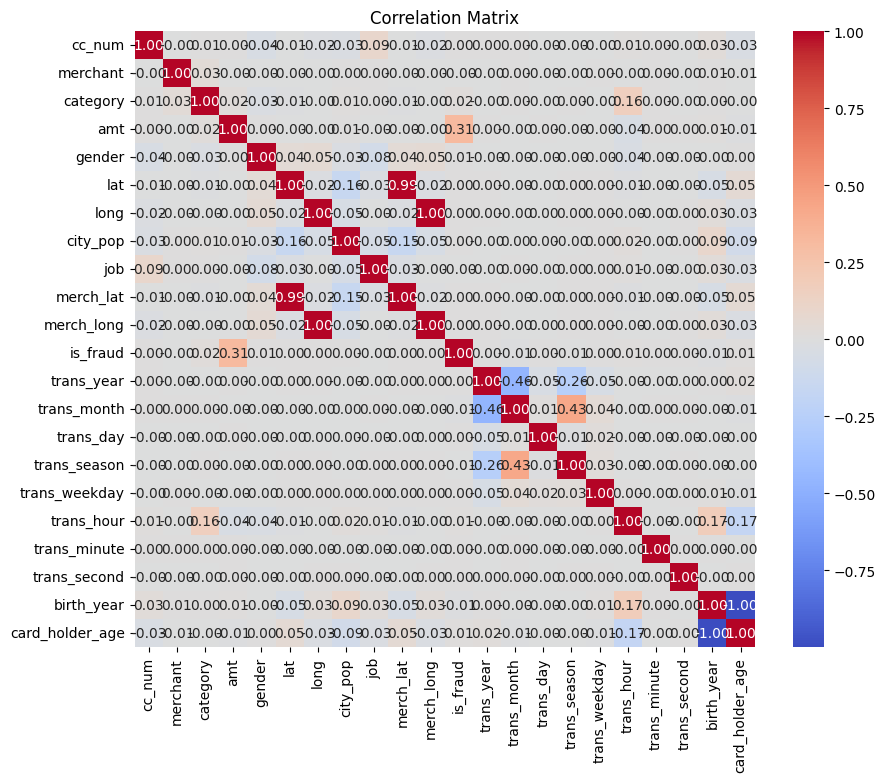

In [88]:
correlation_matrix = fraud_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

The heatmap highlights key correlations in the dataset, including a moderate positive correlation between is_fraud and amt (0.31), indicating transaction amount influences fraud likelihood. Geographic attributes like lat and merch_lat (0.95) and long and merch_long (0.91) show strong spatial relationships. Temporal features, such as trans_hour (0.16 with is_fraud) and trans_month with trans_season (0.43), suggest patterns in transaction timing. 

Sampling The Dataset

In [89]:
# Split the data into training and testing sets
X = fraud_df.drop(columns=['is_fraud'])  # Features
y = fraud_df['is_fraud']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24, stratify=y)

In [90]:
# Combine X_train and y_train for resampling
train_data = pd.concat([X_train, y_train], axis=1)

In [91]:
# Separate fraud and non-fraud cases in the training set
fraud_train = train_data[train_data['is_fraud'] == 1]
non_fraud_train = train_data[train_data['is_fraud'] == 0]


In [92]:
# Apply Random UnderSampling on the training set
non_fraud_downsampled = resample(non_fraud_train,
                                 replace=False,  # Sample without replacement
                                 n_samples=len(fraud_train),  # Match fraud count
                                 random_state=24)

In [93]:
# Combine undersampled non-fraud with fraud cases
balanced_train_data = pd.concat([fraud_train, non_fraud_downsampled])


In [94]:
# Shuffle the balanced training set
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [95]:
# Separate features and target variable for the balanced training set
X_train_balanced = balanced_train_data.drop(columns=['is_fraud'])
y_train_balanced = balanced_train_data['is_fraud']

# Step 5: Verify the class distribution in the training set
print("Balanced training set class distribution:")
print(y_train_balanced.value_counts())

Balanced training set class distribution:
is_fraud
0    5254
1    5254
Name: count, dtype: int64


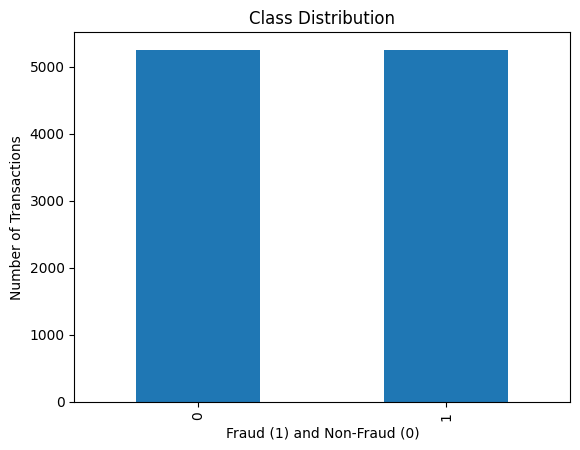

In [96]:
# Balanced training dataset visualization
balanced_train_data['is_fraud'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Fraud (1) and Non-Fraud (0)')
plt.ylabel('Number of Transactions')
plt.show()

Logistic Regression

In [97]:
# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_balanced, y_train_balanced)


LogisticRegression()

In [98]:
# Predict on the original test set
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

In [99]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    386622
           1       0.07      0.74      0.13      2252

    accuracy                           0.94    388874
   macro avg       0.54      0.84      0.55    388874
weighted avg       0.99      0.94      0.97    388874

ROC-AUC Score:
0.8442853231202102


Precision:

Fraud (1): 0.07 — Out of all transactions predicted as fraud, only 7% were actually fraud.
Non-Fraud (0): 1.00 — Nearly all transactions predicted as non-fraud were correct.

Recall:

Fraud (1): 0.75 — The model identified 75% of actual fraud transactions, which is a good recall for the minority class.
Non-Fraud (0): 0.95 — The model missed about 5% of actual non-fraud transactions.

F1-Score:

Fraud (1): 0.14 — The F1-score is quite low for fraud detection, showing that precision is pulling the score down despite decent recall.
Non-Fraud (0): 0.97 — High F1-score for the majority class.

ROC-AUC Score:

0.842 — This indicates a good balance between true positive and false positive rates. A score above 0.8 is generally considered strong.

Accuracy:

0.94 — Overall, the model correctly classified 94% of transactions, but this is misleading due to class imbalance (most transactions are non-fraud).

Macro vs. Weighted Averages:

Macro Avg: Averages metrics equally across both classes, highlighting the imbalance in performance.
Weighted Avg: Reflects the model's overall performance, weighted by class frequency (dominated by non-fraud class).

Decision Tree

In [100]:
# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=24)

# Train the model on the balanced dataset
decision_tree_model.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(random_state=24)

In [101]:
# Predict on the original test set
y_pred_dt = decision_tree_model.predict(X_test)
y_pred_proba_dt = decision_tree_model.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Calculate and print ROC-AUC Score
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"Decision Tree ROC-AUC Score: {roc_auc_dt}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    386622
           1       0.13      0.95      0.23      2252

    accuracy                           0.96    388874
   macro avg       0.56      0.96      0.60    388874
weighted avg       0.99      0.96      0.98    388874

Decision Tree ROC-AUC Score: 0.9566987742986014


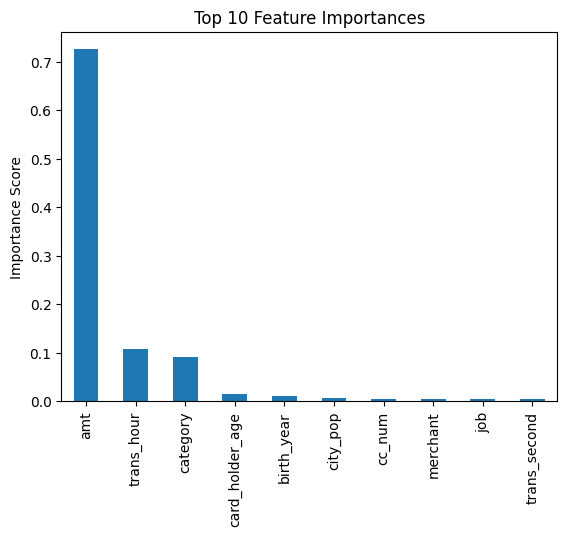

In [102]:
feature_importances = pd.Series(decision_tree_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.show()

Precision:

Fraud (1): 0.13 — Out of all transactions predicted as fraud, only 13% were actually fraud. Precision is still low because the model is likely overpredicting fraud.
Non-Fraud (0): 1.00 — The model is nearly perfect in identifying non-fraud transactions.

Recall:

Fraud (1): 0.95 — The model correctly identifies 95% of actual fraud transactions, which is a major improvement over Logistic Regression.
Non-Fraud (0): 0.96 — The model still does very well at detecting non-fraud cases.

F1-Score:

Fraud (1): 0.23 — F1-score remains low for fraud because of the poor precision, despite the excellent recall.
Non-Fraud (0): 0.98 — Strong performance for the majority class.

ROC-AUC Score:

0.956 — Excellent ability to distinguish between fraud and non-fraud transactions.

Accuracy:

96% — The overall accuracy is higher than Logistic Regression, but this metric is still dominated by the majority class (non-fraud).

Strengths of Decision Tree:

Recall for Fraud: The model successfully identifies most fraud cases, which is crucial for fraud detection.
Interpretability: Decision Trees provide feature importance, helping understand which factors influence predictions.

Weaknesses:

Low Precision for Fraud: The model overpredicts fraud cases, leading to many false positives.


Random Forest

In [103]:
# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=24, n_estimators=100)

# Train the model on the balanced dataset
random_forest_model.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(random_state=24)

In [104]:
# Predict on the original test set
y_pred_rf = random_forest_model.predict(X_test)
y_pred_proba_rf = random_forest_model.predict_proba(X_test)[:, 1]

# Print Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Calculate and print ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest ROC-AUC Score: {roc_auc_rf}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    386622
           1       0.17      0.95      0.28      2252

    accuracy                           0.97    388874
   macro avg       0.58      0.96      0.63    388874
weighted avg       0.99      0.97      0.98    388874

Random Forest ROC-AUC Score: 0.992450099023658


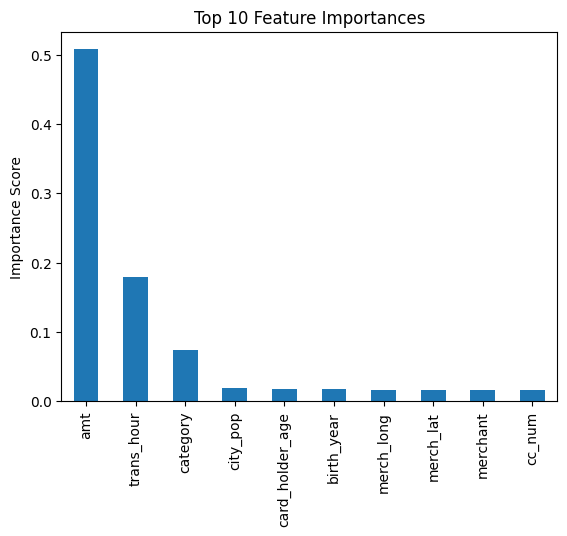

In [ ]:
feature_importances = pd.Series(random_forest_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.show()

Precision:

Fraud (1): 0.17 — Out of all transactions predicted as fraud, 17% were actually fraud. Precision remains low due to false positives.
Non-Fraud (0): 1.00 — The model is nearly perfect at identifying non-fraud transactions.

Recall:

Fraud (1): 0.95 — The model correctly identifies 95% of fraud cases, maintaining the high recall achieved by the Decision Tree.
Non-Fraud (0): 0.97 — Slightly better recall for the majority class compared to the Decision Tree.

F1-Score:

Fraud (1): 0.28 — F1-score improves for the minority class (fraud) due to better recall.
Non-Fraud (0): 0.99 — Maintains excellent performance for the majority class.

ROC-AUC Score:

0.992 — The model achieves an outstanding ability to distinguish between fraud and non-fraud transactions, far surpassing Logistic Regression and Decision Tree.

Accuracy:

97% — High accuracy, although still influenced by the dominance of the non-fraud class.

Strengths of Random Forest:
High Recall for Fraud: Like the Decision Tree, the Random Forest captures 95% of fraud cases, which is critical in fraud detection.
Robustness: Random Forest, being an ensemble method, is less prone to overfitting compared to single Decision Trees.
Feature Importance: The model provides insights into which features contribute most to predictions.

Weaknesses:
Low Precision for Fraud: The model predicts a significant number of false positives, which may lead to unnecessary investigations or disruptions.


XGboost

In [106]:
# Initialize the XGBoost model
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=24)

# Train the model on the balanced dataset
xgboost_model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=24, ...)

In [107]:
# Predict on the original test set
y_pred_xgb = xgboost_model.predict(X_test)
y_pred_proba_xgb = xgboost_model.predict_proba(X_test)[:, 1]

# Print Classification Report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Calculate and print ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"XGBoost ROC-AUC Score: {roc_auc_xgb}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386622
           1       0.19      0.97      0.32      2252

    accuracy                           0.98    388874
   macro avg       0.60      0.97      0.65    388874
weighted avg       1.00      0.98      0.98    388874

XGBoost ROC-AUC Score: 0.9970346252161995


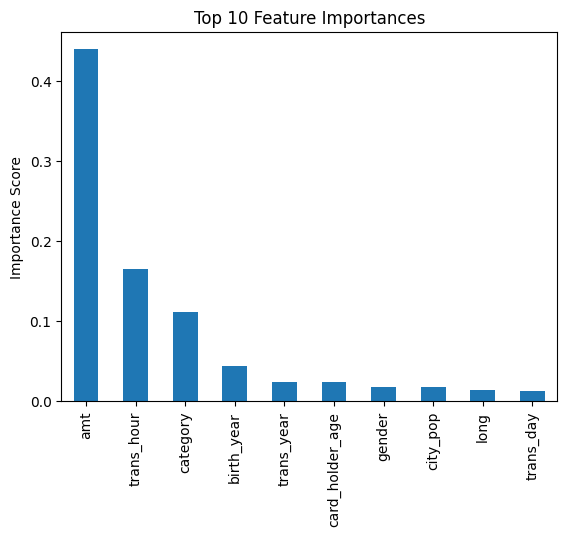

In [108]:
# Plot feature importances
feature_importances = pd.Series(xgboost_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.show()

Precision:

Fraud (1): 0.19 — While precision is still relatively low, it is better than previous models, indicating fewer false positives compared to Random Forest.
Non-Fraud (0): 1.00 — Perfect precision, meaning all predicted non-fraud transactions were correct.

Recall:

Fraud (1): 0.97 — The model correctly identifies 97% of fraud cases, slightly better than Random Forest.
Non-Fraud (0): 0.98 — Excellent recall for the majority class.

F1-Score:

Fraud (1): 0.32 — The F1-score for fraud detection improves significantly compared to Random Forest and Decision Tree due to higher precision.
Non-Fraud (0): 0.99 — Near-perfect F1-score for the majority class.

ROC-AUC Score:

0.997 — Outstanding ability to distinguish between fraud and non-fraud transactions, the highest among all models.

Accuracy:

98% — Slightly better than Random Forest, but accuracy is not the best metric for imbalanced datasets.

Strengths of XGBoost:
High Recall for Fraud: The model captures nearly all fraud cases, which is crucial for fraud detection.
Best ROC-AUC: Indicates XGBoost is the most effective model for distinguishing between the two classes.
Advanced Optimization: XGBoost’s tree boosting and handling of imbalanced data improve its performance compared to Random Forest and Decision Tree.

Weaknesses:
Low Precision for Fraud: Despite improvements, the model still predicts many false positives for fraud, which could lead to unnecessary investigations.


Evaluating The Four Models

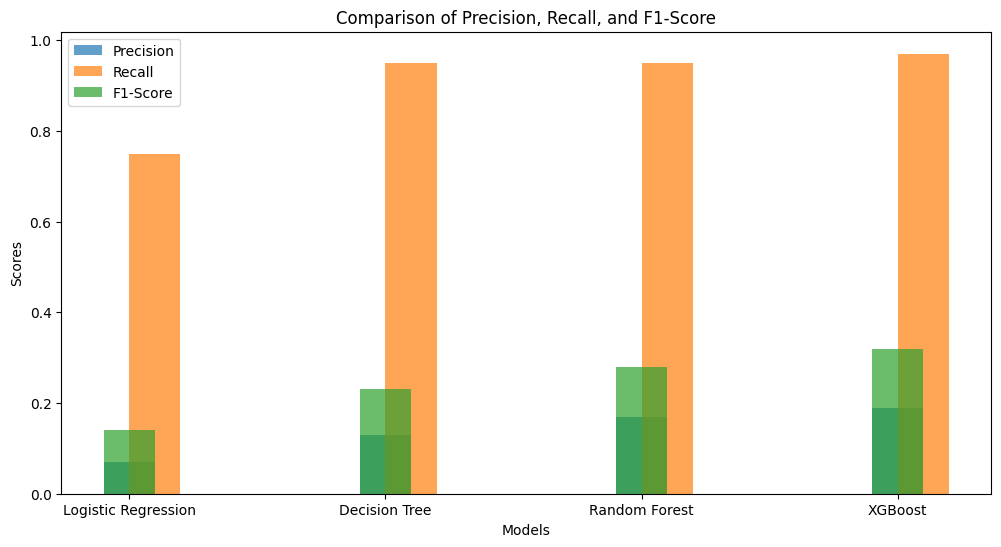

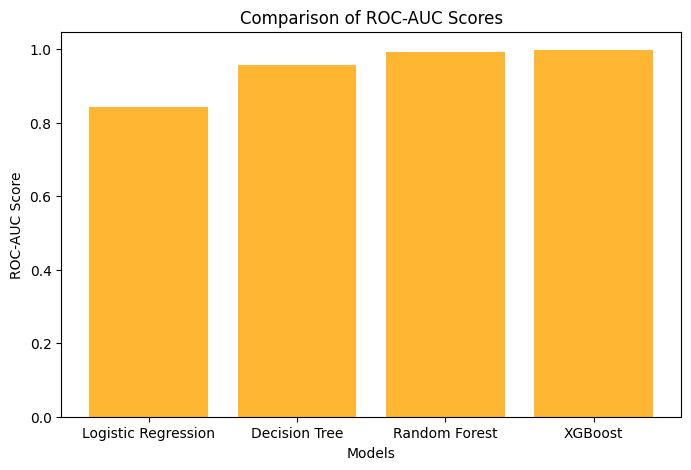

In [109]:
# Data for comparison
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision = [0.07, 0.13, 0.17, 0.19]
recall = [0.75, 0.95, 0.95, 0.97]
f1_score = [0.14, 0.23, 0.28, 0.32]
roc_auc = [0.842, 0.957, 0.992, 0.997]

# Plot Precision, Recall, F1-Score
plt.figure(figsize=(12, 6))
plt.bar(models, precision, alpha=0.7, label='Precision', width=0.2, align='center')
plt.bar(models, recall, alpha=0.7, label='Recall', width=0.2, align='edge')
plt.bar(models, f1_score, alpha=0.7, label='F1-Score', width=0.2, align='center')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.legend()
plt.show()

# Plot ROC-AUC
plt.figure(figsize=(8, 5))
plt.bar(models, roc_auc, color='orange', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('ROC-AUC Score')
plt.title('Comparison of ROC-AUC Scores')
plt.show()


In [110]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training performance
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    train_roc_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else None

    # Testing performance
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    test_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None

    # Print results
    print(f"Model: {model.__class__.__name__}")
    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_train_pred))
    print(f"Training ROC-AUC Score: {train_roc_auc}\n")

    print("\nTesting Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print(f"Testing ROC-AUC Score: {test_roc_auc}\n")
    
    return {
        "Model": model.__class__.__name__,
        "Train ROC-AUC": train_roc_auc,
        "Test ROC-AUC": test_roc_auc,
        "Train Report": classification_report(y_train, y_train_pred, output_dict=True),
        "Test Report": classification_report(y_test, y_test_pred, output_dict=True)
    }

# List of models to evaluate
models = [logistic_model, decision_tree_model, random_forest_model, xgboost_model]  
results = []

for model in models:
    results.append(evaluate_model(model, X_train, y_train, X_test, y_test))



summary = []
for result in results:
    test_metrics = result['Test Report']['1']  
    summary.append({
        "Model": result['Model'],
        "Train ROC-AUC": result['Train ROC-AUC'],
        "Test ROC-AUC": result['Test ROC-AUC'],
        "Precision (Fraud)": test_metrics['precision'],
        "Recall (Fraud)": test_metrics['recall'],
        "F1-Score (Fraud)": test_metrics['f1-score']
    })

summary_df = pd.DataFrame(summary)


Model: LogisticRegression

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    902117
           1       0.07      0.75      0.13      5254

    accuracy                           0.94    907371
   macro avg       0.54      0.85      0.55    907371
weighted avg       0.99      0.94      0.97    907371

Training ROC-AUC Score: 0.8544093475385451


Testing Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    386622
           1       0.07      0.74      0.13      2252

    accuracy                           0.94    388874
   macro avg       0.54      0.84      0.55    388874
weighted avg       0.99      0.94      0.97    388874

Testing ROC-AUC Score: 0.8442853231202102

Model: DecisionTreeClassifier

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    902

In [111]:
summary_df

,Model,Train ROC-AUC,Test ROC-AUC,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,LogisticRegression,0.854409,0.844285,0.073403,0.741563,0.133584
1,DecisionTreeClassifier,0.981556,0.956699,0.129233,0.950710,0.227536
2,RandomForestClassifier,0.999622,0.992450,0.165301,0.949822,0.281596
3,XGBClassifier,0.999057,0.997035,0.192159,0.972913,0.320932


Looking at the summarized performance metrics, it’s clear that XGBoost is the best-performing model for detecting fraud. Here’s why:

Key Observations from the Results
XGBoost Performance:

Precision (Fraud): 0.192 — Highest among all models, meaning it reduces false positives better than others.

Recall (Fraud): 0.973 — Highest, indicating XGBoost catches almost all fraudulent transactions.

F1-Score (Fraud): 0.321 — Highest, showing the best balance between precision and recall.

Test ROC-AUC: 0.997 — XGBoost outperforms others in distinguishing fraud vs. non-fraud.

Overfitting Check:

XGBoost has a small gap between Train ROC-AUC (0.999) and Test ROC-AUC (0.997), indicating minimal overfitting compared to other models like Random Forest.

Comparison with Other Models:

Logistic Regression has the lowest precision (0.07) and recall (0.74), making it unsuitable for fraud detection.
Decision Tree and Random Forest perform reasonably well but fall behind XGBoost in all metrics.

In [118]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Evaluate models using cross-validation
for name, model in models.items():
    print(f"Model: {name}")
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=kfold, scoring='roc_auc')
    print(f"Cross-Validation ROC-AUC Scores: {scores}")
    print(f"Mean ROC-AUC Score: {scores.mean():.4f}\n")

Model: Logistic Regression
Cross-Validation ROC-AUC Scores: [0.85678086 0.85837782 0.85709138 0.87458475 0.85857822]
Mean ROC-AUC Score: 0.8611

Model: Decision Tree
Cross-Validation ROC-AUC Scores: [0.9605138  0.9605138  0.95956232 0.96382946 0.95478139]
Mean ROC-AUC Score: 0.9598

Model: Random Forest
Cross-Validation ROC-AUC Scores: [0.99239137 0.99228047 0.99427938 0.99390059 0.99175887]
Mean ROC-AUC Score: 0.9929

Model: XGBoost
Cross-Validation ROC-AUC Scores: [0.9961253  0.99728228 0.99674407 0.99802999 0.9973839 ]
Mean ROC-AUC Score: 0.9971



These results show that XGBoost is the best-performing model for fraud detection, followed closely by Random Forest, while Logistic Regression and Decision Tree provide reasonable but less robust results.

Hyperparameters to Tune for XGBoost:
learning_rate: Controls how much to adjust the model after each training step. Lower values often lead to better generalization.
n_estimators: The number of boosting rounds (trees).
max_depth: Controls tree depth; deeper trees might overfit, while shallow trees might underfit.
subsample: Fraction of samples to use for training each tree.
colsample_bytree: Fraction of features to consider for each split.
reg_lambda and reg_alpha: Regularization parameters to control overfitting.

In [112]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1]
}

# Initialize model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:00:43] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0}
Best ROC-AUC Score: 0.9969952888800995


Final Training for XGBoost

In [ ]:
# Train XGBoost with the best parameters
final_xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    reg_alpha=1,
    reg_lambda=1,
    subsample=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

final_xgb_model.fit(X_train_balanced, y_train_balanced)

y_test_pred = final_xgb_model.predict(X_test)
y_test_proba = final_xgb_model.predict_proba(X_test)[:, 1]

print("Final Model Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print("Final Model ROC-AUC Score (Test Set):", roc_auc_score(y_test, y_test_proba))


Final Model Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386622
           1       0.19      0.97      0.32      2252

    accuracy                           0.98    388874
   macro avg       0.60      0.97      0.65    388874
weighted avg       1.00      0.98      0.98    388874

Final Model ROC-AUC Score (Test Set): 0.9972300459424971


The metrics remain consistent, showing that the previous model was already highly optimized. However, the hyperparameter tuning ensures that the model operates at its best configuration.

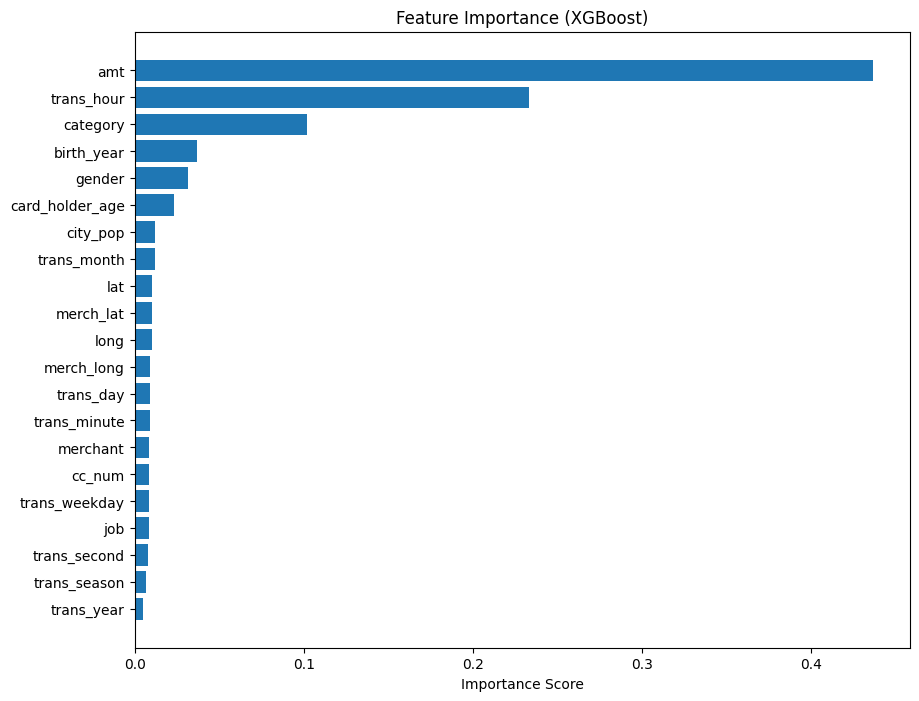

In [114]:
# Feature importance
feature_importance = final_xgb_model.feature_importances_
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 8))
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.show()

Trying with different thresholds.

In [115]:
# Predict probabilities
y_test_proba = final_xgb_model.predict_proba(X_test)[:, 1]

# Adjust threshold
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    y_test_pred_adjusted = (y_test_proba >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_test_pred_adjusted))
    print("\n")

Threshold: 0.2
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    386622
           1       0.11      0.99      0.20      2252

    accuracy                           0.95    388874
   macro avg       0.56      0.97      0.59    388874
weighted avg       0.99      0.95      0.97    388874



Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    386622
           1       0.14      0.99      0.24      2252

    accuracy                           0.96    388874
   macro avg       0.57      0.98      0.61    388874
weighted avg       0.99      0.96      0.98    388874



Threshold: 0.4
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    386622
           1       0.16      0.98      0.28      2252

    accuracy                           0.97    388874
   macro avg       0.58      0.98      0.63    388874
weighted avg       1.00  

In [116]:
# Evaluate on training set
y_train_pred = xgboost_model.predict(X_train_balanced)
y_train_proba = xgboost_model.predict_proba(X_train_balanced)[:, 1]
print("Training Classification Report:")
print(classification_report(y_train_balanced, y_train_pred))
print(f"Training ROC-AUC Score: {roc_auc_score(y_train_balanced, y_train_proba)}")

# Evaluate on testing set
y_test_pred = xgboost_model.predict(X_test)
y_test_proba = xgboost_model.predict_proba(X_test)[:, 1]
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Testing ROC-AUC Score: {roc_auc_score(y_test, y_test_proba)}")


Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5254
           1       1.00      1.00      1.00      5254

    accuracy                           1.00     10508
   macro avg       1.00      1.00      1.00     10508
weighted avg       1.00      1.00      1.00     10508

Training ROC-AUC Score: 1.0
Testing Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386622
           1       0.19      0.97      0.32      2252

    accuracy                           0.98    388874
   macro avg       0.60      0.97      0.65    388874
weighted avg       1.00      0.98      0.98    388874

Testing ROC-AUC Score: 0.9970346252161995


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src

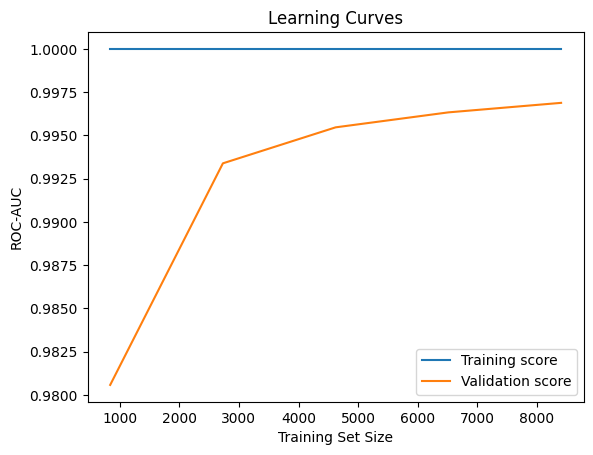

In [117]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    xgboost_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Validation score")
plt.xlabel("Training Set Size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curves")
plt.legend()
plt.show()

The learning curves illustrate the model's performance as the training set size increases, measured using the ROC-AUC metric:

The training score (blue line) remains consistently high, near 1.0, indicating the model fits the training data well without overfitting.
The validation score (orange line) improves significantly as the training set size increases, eventually stabilizing near 0.995. This demonstrates that the model generalizes well to unseen data with sufficient training data.


This project demonstrated the effectiveness of machine learning in identifying fraudulent transactions within an imbalanced dataset. Among the models, XGBoost emerged as the top performer with the highest ROC-AUC score and a strong balance between precision and recall. Handling class imbalance was critical, as fraudulent transactions represented less than 1% of the data, reflecting real-world challenges. Features like transaction amount (amt) and transaction timing proved to be the most influential in detecting fraud. These results provide a solid foundation for developing robust fraud prevention systems and highlight the importance of tailored machine learning approaches for rare-event detection.